In [1]:
from IPython.display import display
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import msreport

sys.path.append("..")
from python_scripts import ticplot

In [2]:
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.family"] = "Arial"

## Define parameters, load qtables

In [3]:
qtable_dir = "../qtable_data"
qtable_basenames = [
    "GFP-Atg8_acetylated",
    "GFP-Atg8_untreated",
]
output_dir = "../plots/figure_4"
treatments = ["GFP-Atg8_untreated", "GFP-Atg8_acetylated"]

In [4]:
qtables = {}
for qtable_basename in qtable_basenames: 
    qtable = msreport.Qtable.load(qtable_dir, qtable_basename)
    qtables[qtable_basename] = qtable

## Plot figure

In [5]:
figname = "ratio_plots_acetylated_vs_untreated.pdf"
figpath = os.path.join(output_dir, figname)

In [6]:
tables = []
treatment_columns = {}
for treatment in treatments:
    qtable = qtables[treatment]
    experiment = [e for e in qtable.get_experiments() if "Atg8" in e][0]
    samples = qtable.get_samples(experiment)
    expression_columns = [qtable.get_expression_column(sample) for sample in samples]
    treatment_columns[treatment] = expression_columns

    mask = (qtable[f"Events {experiment}"] == 3) & ~qtable["Potential contaminant"]
    columns = ["Representative protein"] + expression_columns
    table = qtable.data.loc[mask, columns]
    table.set_index("Representative protein", inplace=True)
    tables.append(table)
protein_table = tables[0].join(tables[1], how="inner")
protein_table.reset_index(inplace=True)

In [7]:
def calculate_median_ratios(table, cols1, cols2) -> list[float]:
    medians = []
    for col1, col2 in zip(cols1, cols2):
        medians.append(np.median(table[col2] - table[col1]))
    return np.power(2, medians)

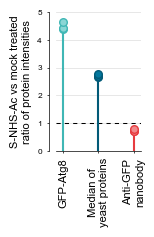

In [8]:
cols1 = treatment_columns[treatments[0]]
cols2 = treatment_columns[treatments[1]]

selection = protein_table["Representative protein"] == "3OGO"
nanobody_ratios = calculate_median_ratios(protein_table[selection], cols1, cols2)

selection = protein_table["Representative protein"] != "3OGO"
yeast_ratios = calculate_median_ratios(protein_table[selection], cols1, cols2)

selection = protein_table["Representative protein"] == "P38182"
atg8_ratios = calculate_median_ratios(protein_table[selection], cols1, cols2)

ratio_groups = [atg8_ratios, yeast_ratios, nanobody_ratios]
xtick_labels = ["GFP-Atg8", "Median of\nyeast proteins", "Anti-GFP\nnanobody"]

colors = ["#40B7B5", "#025a77", "#E73C40"]
colors_light = ["#8ad6d5", "#03779d", "#f18a8c"]

fig, ax = plt.subplots(figsize=[1.1, 1.8])
for position, ratios in enumerate(ratio_groups):
    ratios = sorted(ratios)
    # x_points = [position + shift for shift in [0.1, -0.1, 0]]
    x_points = [position] * len(ratios)
    color = colors[position]
    light_color = colors_light[position]
    ax.plot(
        [position, position],
        [0, np.mean(ratios)],
        lw=1.5,
        color=color,
        zorder=3
    )
    ax.scatter(
        x_points,
        ratios,
        s=30,
        edgecolor=color,
        color=light_color,
        zorder=3
    )

# Spines
sns.despine(right=True, top=True, left=False, bottom=False)
for spine in ax.spines.values():
    spine.set_color("#000000")
    spine.set_linewidth(0.5)
ax.spines["left"].set_position(("outward", 5))

# Add a line at ratio 1
xlim = ax.get_xlim()
xlim = (xlim[0] - 0.1, xlim[1] + 0.1)
ax.plot(xlim, [1, 1], color="#000000", lw=0.75, zorder=2, dashes=(4, 4))

# Set limits
ax.set_ylim(0, 5)
ax.set_xlim(xlim)

# Adjust grind lines
ax.yaxis.grid(
    which="both",
    linestyle="solid",
    # dashes=(4, 1.5),
    lw=0.5,
    alpha=1,
    color="#DDDDDD",
    zorder=0,
)
ax.xaxis.grid(False, which="both")

# Tick and tick labels
ax.tick_params(
    direction="out",
    length=1.5,
    width=0.5,
    colors="#000000",
    top=False,
    right=False,
    labelsize=6,
)
ax.set_ylabel("S-NHS-Ac vs mock treated\nratio of protein intensities", fontsize=8)
ax.set_xticks(
    range(len(xtick_labels)),
    xtick_labels,
    rotation=90,
    fontsize=8,
)

fig.savefig(figpath, dpi=300)
    